# Default mode connectivity in ANTsPy

We implement a simple processing stream showing how we can manipulate human connectome project data in ANTsPy.

In [1]:
import os
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "4"
os.environ[ "ANTS_RANDOM_SEED" ] = "3"
import ants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Legendre
from scipy import linalg
from scipy.stats.stats import pearsonr
# exec(open("src/sfJointReg.py").read())
powers_areal_mni_itk = pd.read_csv(ants.get_data('powers_mni_itk')) # power coordinates

Set up data locations and symmetrize the bold images.

In [2]:
rdir = "../"
id = '2001'
t1fn = rdir + 'data/LS' + id + "/unprocessed/3T/T1w_MPR1/LS"+id+"_3T_T1w_MPR1_gdc.nii.gz"
# now the bold data
boldfnsL = rdir + "data/LS2001/LS2001fmri/unprocessed/3T/rfMRI_REST1_LR/LS2001_3T_rfMRI_REST1_LR_gdc.nii.gz"
boldfnsR = rdir + "data/LS2001/LS2001fmri/unprocessed/3T/rfMRI_REST1_RL/LS2001_3T_rfMRI_REST1_RL_gdc.nii.gz"
# get the ref data
reffns1 = rdir + 'data/LS2001/LS2001fmri/unprocessed/3T/rfMRI_REST1_LR/LS2001_3T_rfMRI_REST1_LR_SBRef_gdc.nii.gz'
reffns2 = rdir + 'data/LS2001/LS2001fmri/unprocessed/3T/rfMRI_REST1_RL/LS2001_3T_rfMRI_REST1_RL_SBRef_gdc.nii.gz'

##  Distortion correction (without a field map)

i1 = ants.image_read( reffns1 )
i2 = ants.image_read( reffns2 )
und = ants.build_template( i1, ( i1, i2 ), 3, gradient_step = 0.5 )
t1 = ants.image_read( t1fn ).n3_bias_field_correction( 8 ).n3_bias_field_correction( 4 )
bmask = ants.get_mask( und, low_thresh = und.mean() * 0.75, high_thresh=1e9, cleanup = 3 ).iMath_fill_holes()

0.30371636
0.19880252
0.1547944


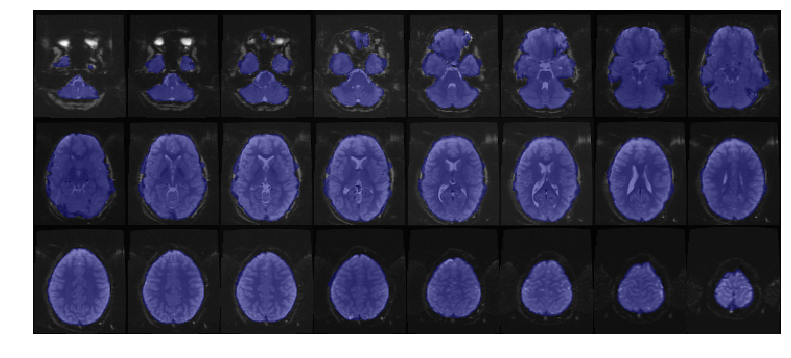

In [3]:
ants.plot( und, bmask, axis=2, overlay_alpha=0.5, ncol=8, nslices=24 )

map to the t1

In [4]:
t1mask = ants.get_mask( t1, low_thresh = t1.mean() * 1.1, high_thresh=1e9, cleanup = 5 ).iMath_fill_holes()
# ants.plot( t1, t1mask, axis=2, overlay_alpha = 0.33 )
t1rig = ants.registration( und * bmask, t1 * t1mask, "BOLDRigid" )
t1reg = ants.registration( und * bmask, t1 * t1mask, "SyNOnly",
  initialTransform = t1rig['fwdtransforms'],
  synMetric = 'CC', synSampling = 2, regIterations = (5) )

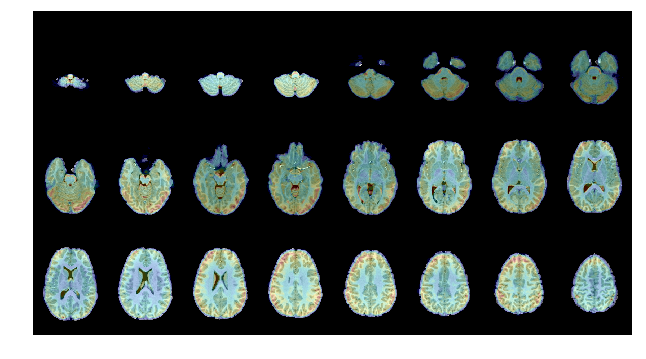

In [5]:
ants.plot( t1*t1mask, t1reg['warpedfixout'] , axis=2, overlay_alpha=0.25, ncol=8, nslices=24 )

continue on to the rest of the study that will result in a BOLD correlation map

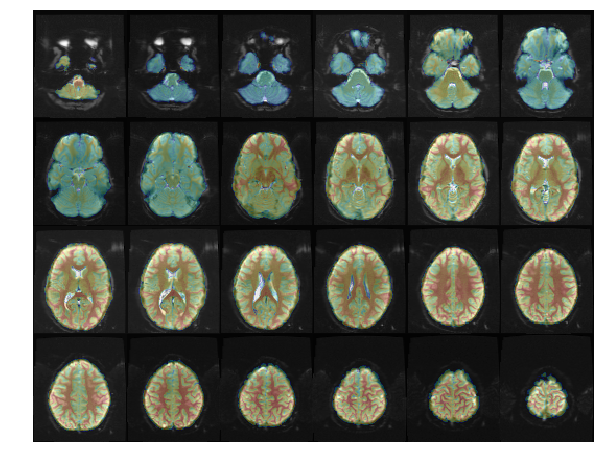

In [6]:
ants.plot( und, t1reg['warpedmovout'], overlay_alpha = 0.25, axis=2, nslices=24, ncol=6 )

In [7]:
t1maskFromBold = ants.apply_transforms( t1, bmask, t1reg['invtransforms'],
                                      interpolator = 'nearestNeighbor' )
t1 = ants.n4_bias_field_correction( t1, t1mask, 8 ).n4_bias_field_correction( t1mask, 4 )
bmask =  ants.apply_transforms( und, t1mask, t1reg['fwdtransforms'],
  interpolator = 'nearestNeighbor' ).morphology("close",3)
ofn = rdir + "features/LS" + id + "_mask_py.nii.gz"
t1toBOLD = ants.apply_transforms( und, t1, t1reg['fwdtransforms'] )
ofn = rdir + "features/LS" + id + "_t1ToBold_py.nii.gz"
# ants.image_write( t1toBOLD, ofn )

## Tissue segmentation
# a simple method
################################################
qt1 = ants.iMath_truncate_intensity( t1, 0, 0.95 )
t1seg = ants.kmeans_segmentation( qt1, 3, t1mask, 0.2 )
volumes = ants.label_stats( t1seg['segmentation'], t1seg['segmentation'] )

boldseg = ants.apply_transforms( und, t1seg['segmentation'],
  t1reg['fwdtransforms'], interpolator = 'nearestNeighbor' )

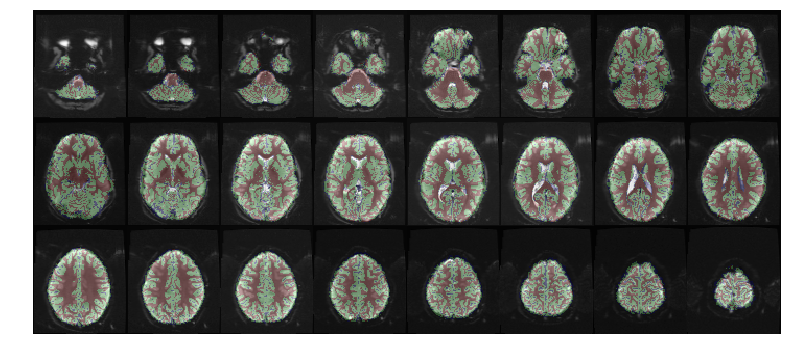

In [8]:
ants.plot(   und,   boldseg,  overlay_alpha = 0.25 , axis = 2, nslices = 24, ncol=8)

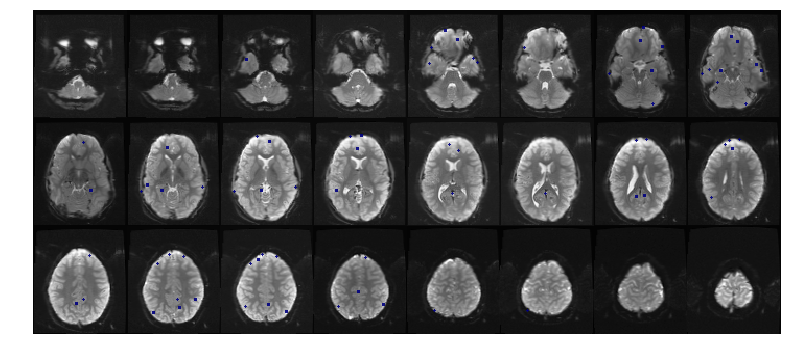

In [23]:
## Template mapping
# include prior information e.g. from meta-analysis or anatomy

myvoxes = range(powers_areal_mni_itk.shape[0])
anat = powers_areal_mni_itk['Anatomy']
syst = powers_areal_mni_itk['SystemName']
Brod = powers_areal_mni_itk['Brodmann']
xAAL  = powers_areal_mni_itk['AAL']
ch2 = ants.image_read( ants.get_ants_data( "ch2" ) )
if 'treg' not in globals():
    treg = ants.registration( t1 * t1mask, ch2, 'SyN' )

concatx2 = treg['invtransforms'] + t1reg['invtransforms']
pts2bold = ants.apply_transforms_to_points( 3, powers_areal_mni_itk, concatx2,whichtoinvert = ( True, False, True, False ) )
locations = pts2bold.iloc[:,:3].values
ptImg = ants.make_points_image( locations, bmask, radius = 2 )
anat = powers_areal_mni_itk['AAL'].unique()
postCing = powers_areal_mni_itk['AAL'].unique()[9]
networks = powers_areal_mni_itk['SystemName'].unique()
dfnpts1 = np.where( powers_areal_mni_itk['SystemName'] == networks[5] )
ww = np.where( powers_areal_mni_itk['SystemName'] == networks[5] )[0]
dfnImg = ants.make_points_image(pts2bold.iloc[ww,:3].values, bmask, radius=1).threshold_image( 1, 400 )
ants.plot( und, dfnImg, axis=2, nslices=24, ncol=8 )

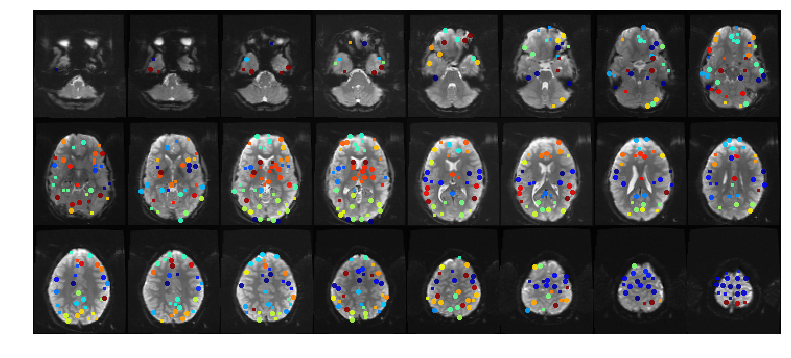

In [10]:
ants.plot( und, ptImg, axis=2, nslices=24, ncol=8 )

Progress:
0%.10%.20%.30%.40%.50%.60%.70%.80%.90%.100%.Done


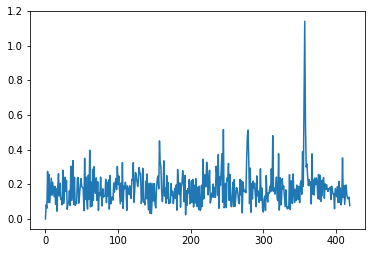

In [11]:
# Extracting canonical functional network maps
## preprocessing

csfAndWM = ( ants.threshold_image( boldseg, 1, 1 ) +
             ants.threshold_image( boldseg, 3, 3 ) ).morphology("erode",1)
bold = ants.image_read( boldfnsR )
boldList = ants.ndimage_to_list( bold )
avgBold = ants.get_average_of_timeseries( bold, range( 5 ) )
boldUndTX = ants.registration( und, avgBold, "SyN", regIterations = (15,4),
  synMetric = "CC", synSampling = 2, verbose = False )
boldUndTS = ants.apply_transforms( und, bold, boldUndTX['fwdtransforms'], imagetype = 3  )
if 'motCorr' not in globals():
    motCorr = ants.motion_correction( boldUndTS, avgBold,
        type_of_transform="Rigid", verbose = True )

avgBold = ants.get_average_of_timeseries( motCorr['motion_corrected'], range( 5 ) )
#######################
nt = len(motCorr['FD'])
plt.plot(  range( nt ), motCorr['FD'] )
plt.show()


since we have motion correction done, we can move on to DFN correlations. First compcor.

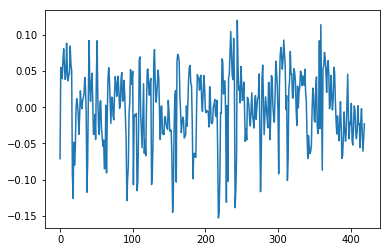

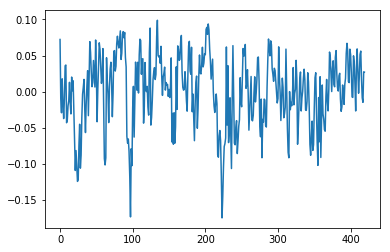

In [12]:
#################################################
mycompcor = ants.compcor( motCorr['motion_corrected'],
  ncompcor=4, quantile=0.95, mask = csfAndWM,
  filter_type='polynomial', degree=2 )
##########
plt.plot(  range( nt ), mycompcor['components'][:,0] )
plt.show()
plt.plot(  range( nt ), mycompcor['components'][:,1] )
plt.show()

Next compute the signal within the GM, regress out nuisance and show the resulting correlations.

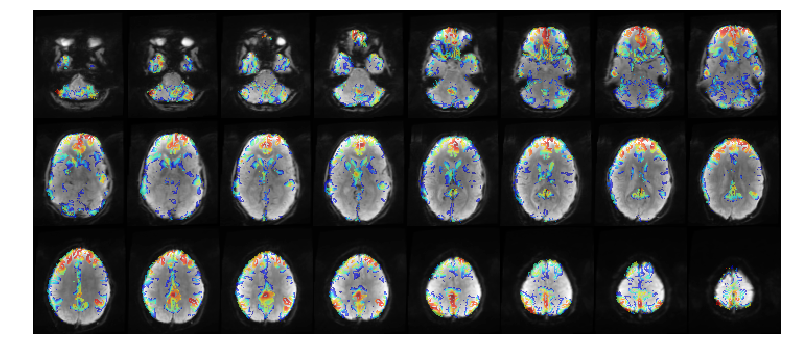

In [24]:
tr = ants.get_spacing( bold )[3]
highMotionTimes = np.where( motCorr['FD'] >= 0.5 )
goodtimes = np.where( motCorr['FD'] < 0.5 )
spa, spt = 1.5, 0.0 # spatial, temporal - which we ignore b/c of frequency filtering
smth = ( spa, spa, spa, spt ) # this is for sigmaInPhysicalCoordinates = F
simg = ants.smooth_image( motCorr['motion_corrected'], smth, sigma_in_physical_coordinates = False )
gmseg = ants.threshold_image( boldseg, 2, 2 )

# define nuisance variables
nuisance = mycompcor['components']
nuisance = np.c_[ nuisance, motCorr['FD'] ]
nuisance = np.c_[ nuisance, mycompcor['basis'] ]

# filtering for all gray matter
gmmat = ants.timeseries_to_matrix( simg, gmseg )
gmmat = ants.bandpass_filter_matrix( gmmat, tr = tr ) # some would argue against this
gmmat = ants.regress_components( gmmat[goodtimes[0],:], nuisance[goodtimes[0],:] )

# filtering for reference region against which we correlate
dfnmat = ants.timeseries_to_matrix( simg, ants.threshold_image( dfnImg * gmseg, 1, dfnImg.max() ) )
dfnmat = ants.bandpass_filter_matrix( dfnmat, tr = tr )
dfnmat = ants.regress_components( dfnmat[goodtimes[0],:], nuisance[goodtimes[0],:] )
dfnsignal = dfnmat.mean( axis = 1 )

gmmatDFNCorr = np.zeros( gmmat.shape[1] )
for k in range( gmmat.shape[1] ):
    gmmatDFNCorr[ k ] = pearsonr( dfnsignal, gmmat[:,k] )[0]

corrImg = ants.make_image( gmseg, gmmatDFNCorr  )

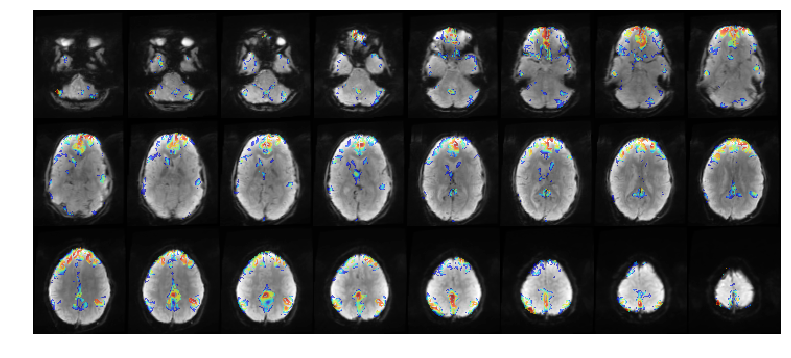

In [25]:
corrImgPos = corrImg * ants.threshold_image( corrImg, 0.5, 1 )
ants.plot( avgBold, corrImgPos, axis=2, overlay_alpha = 0.6, cbar=False, nslices = 24, ncol=8, cbar_length=0.3, cbar_vertical=True )